# Задание №6 (работы 11-12)

In [16]:
! pip uninstall umap-learn==0.5.1
! pip install fuzzy-c-means

^C


ERROR: Could not find a version that satisfies the requirement fcmeans (from versions: none)
ERROR: No matching distribution found for fcmeans


## Подготовка данных

### Загрузка, масштабирование, понижение размерности

In [16]:
from typing import NamedTuple
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report

class ScaledData(NamedTuple):
    umap: object
    tsne: object

prepared_data_file = f".{os.sep}data{os.sep}scaled.csv"

if not os.path.isfile(prepared_data_file):
    # Если вы попали сюда - вам придётся столкнуться с увлекательным конфликтом 
    # пакетов UMAP и fcmeans. Наслаждайтесь!

    from umap import UMAP
    from sklearn.manifold import TSNE
    from sklearn.preprocessing import RobustScaler

    data = pd.read_csv('./data/ionosphere.data', header=None) # Load data

    X = data[range(0, 34)]
    y = data[34].map({"g": 1, "b": 0})
    y.name = "class"

    scaler = RobustScaler() # Выбран так как в предыдущей работе показал наилучшую эффективность.
    umap_reducer = UMAP()
    tsne_reducer = TSNE(init='random', learning_rate='auto')

    scaler.fit(X)

    X_scaled_reduced = [
        umap_reducer.fit_transform(scaler.transform(X)),
        tsne_reducer.fit_transform(scaler.transform(X)),
    ]

    X = ScaledData(
        umap=pd.DataFrame(X_scaled_reduced[0], columns=['p1u', 'p2u']),
        tsne=pd.DataFrame(X_scaled_reduced[1], columns=['p1t', 'p2t'])
    )
    _all = X.umap.join(X.tsne).join(y)
    
    _all.to_csv(prepared_data_file)

else:
    all_scaled_data = pd.read_csv(prepared_data_file)
    y = all_scaled_data["class"]
    X = ScaledData(
        umap=all_scaled_data[['p1u', 'p2u']],
        tsne=all_scaled_data[['p1t', 'p2t']]
    )

## Кластеризация

In [58]:
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import DBSCAN, KMeans
from fcmeans import FCM

_clusterizers = lambda: [ 
    KMeans(max_iter=1000, n_clusters=10), 
]
_params = [
    { 'n_clusters': np.linspace(2, 10, 9, dtype=np.int32), 'max_iter': np.linspace(100, 1000, 10, dtype=np.int32) },
]

clusterizers_umap = []
clusterizers_tsne = []

for c, p in zip(_clusterizers(), _params):
    seracher = GridSearchCV(c, p)
    seracher.fit(X.umap.to_numpy()).best_estimator_
    clusterizers_umap.append(seracher.best_estimator_)

for c, p in zip(_clusterizers(), _params):
    seracher = GridSearchCV(c, p)
    seracher.fit(X.tsne.to_numpy()).best_estimator_
    clusterizers_tsne.append(seracher.best_estimator_)

clusterizers_umap.append(DBSCAN(eps=0.5, min_samples=5).fit(X.umap))
fcm = FCM(n_clusters=4)
fcm.fit(X.umap.to_numpy()) 
clusterizers_umap.append(fcm)

clusterizers_tsne.append(DBSCAN(eps=0.5, min_samples=5).fit(X.umap))
fcm = FCM(n_clusters=4)
fcm.fit(X.tsne.to_numpy()) 
clusterizers_tsne.append(fcm)


## Визуализация

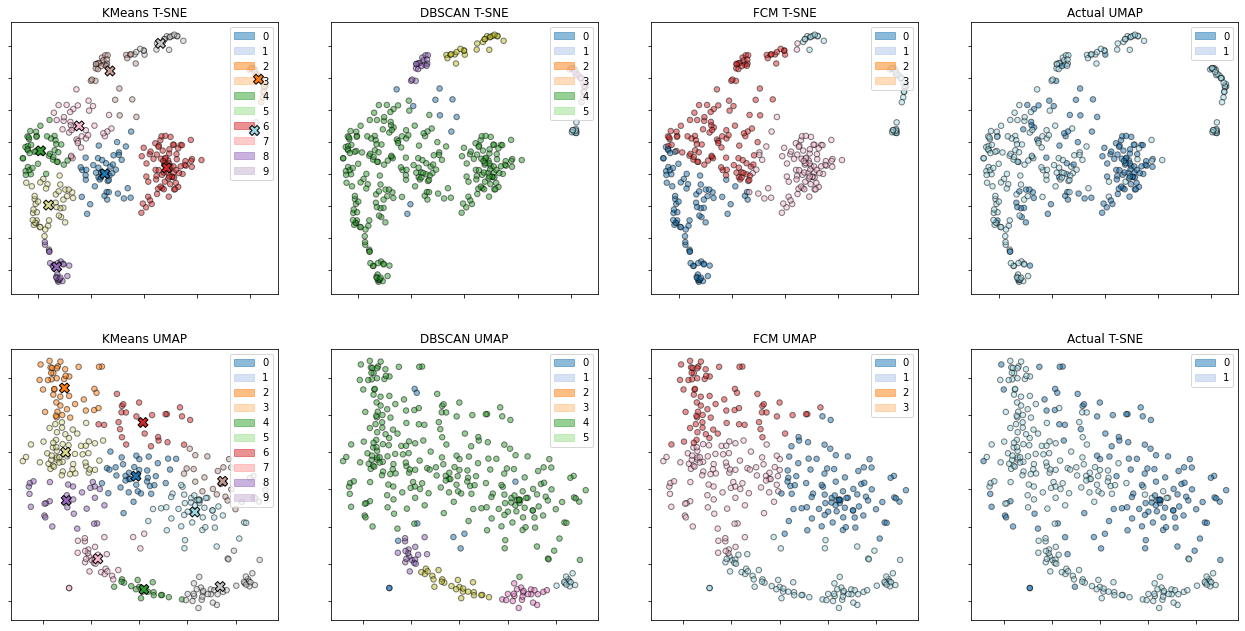

In [68]:
fig, ax = plt.subplots(2, 4)
fig.set_size_inches(22, 11)
features_umap = X.umap.to_numpy()
features_tsne = X.tsne.to_numpy()

for clusterizer_index, clusterizer in enumerate(clusterizers_umap):
    predicted = clusterizer.labels_ if isinstance(clusterizer, DBSCAN) else clusterizer.predict(features_umap)
    if hasattr(clusterizer, 'cluster_centers_'):
        centers = clusterizer.cluster_centers_
    colormap = 'tab20'
    labels = np.unique(predicted).tolist()
    palette = np.array(sns.color_palette(colormap, n_colors=len(labels)))
    cmap = sns.color_palette(colormap, as_cmap=True)

    patchs = []
    for i, color in enumerate(palette):
        patchs.append(mpatches.Patch(color=color, label=i, alpha=0.5))

    ax[0][clusterizer_index].scatter(features_umap[:, 0], features_umap[:, 1], c=predicted, cmap=cmap, s=30, edgecolors='k', alpha=0.5)
    if hasattr(clusterizer, 'cluster_centers_'):
        ax[0][clusterizer_index].scatter(centers[:, 0], centers[:, 1], c=labels, cmap=cmap, s=100, edgecolors='k', marker='X', zorder=10)
    ax[0][clusterizer_index].axis('off')
    ax[0][clusterizer_index].legend(handles=patchs, loc='upper right')
    ax[0][clusterizer_index].set_title(type(clusterizer).__name__ + " T-SNE")
    ax[0][clusterizer_index].axis('on')
    ax[0][clusterizer_index].tick_params(labelbottom=False, labelleft=False)


for clusterizer_index, clusterizer in enumerate(clusterizers_tsne):
    predicted = clusterizer.labels_ if isinstance(clusterizer, DBSCAN) else clusterizer.predict(features_tsne)
    if hasattr(clusterizer, 'cluster_centers_'):
        centers = clusterizer.cluster_centers_
    colormap = 'tab20'
    labels = np.unique(predicted).tolist()
    palette = np.array(sns.color_palette(colormap, n_colors=len(labels)))
    cmap = sns.color_palette(colormap, as_cmap=True)

    patchs = []
    for i, color in enumerate(palette):
        patchs.append(mpatches.Patch(color=color, label=i, alpha=0.5))

    ax[1][clusterizer_index].scatter(features_tsne[:, 0], features_tsne[:, 1], c=predicted, cmap=cmap, s=30, edgecolors='k', alpha=0.5)
    if hasattr(clusterizer, 'cluster_centers_'):
        ax[1][clusterizer_index].scatter(centers[:, 0], centers[:, 1], c=labels, cmap=cmap, s=100, edgecolors='k', marker='X', zorder=10)
    ax[1][clusterizer_index].axis('off')
    ax[1][clusterizer_index].legend(handles=patchs, loc='upper right')
    ax[1][clusterizer_index].set_title(type(clusterizer).__name__ + " UMAP")
    ax[1][clusterizer_index].axis('on')
    ax[1][clusterizer_index].tick_params(labelbottom=False, labelleft=False)

labels = np.unique(y).tolist()
palette = np.array(sns.color_palette(colormap, n_colors=len(labels)))
cmap = sns.color_palette(colormap, as_cmap=True)
patchs = []
for j, color in enumerate(palette):
    patchs.append(mpatches.Patch(color=color, label=j, alpha=0.5))
ax[0][3].scatter(features_umap[:, 0], features_umap[:, 1], c=y, cmap=cmap, s=30, edgecolors='k', alpha=0.5)
ax[0][3].axis('off')
ax[0][3].legend(handles=patchs, loc='upper right')
ax[0][3].set_title('Actual UMAP')
ax[0][3].axis('on')
ax[0][3].tick_params(labelbottom=False, labelleft=False)

labels = np.unique(y).tolist()
palette = np.array(sns.color_palette(colormap, n_colors=len(labels)))
cmap = sns.color_palette(colormap, as_cmap=True)
patchs = []
for j, color in enumerate(palette):
    patchs.append(mpatches.Patch(color=color, label=j, alpha=0.5))
ax[1][3].scatter(features_tsne[:, 0], features_tsne[:, 1], c=y, cmap=cmap, s=30, edgecolors='k', alpha=0.5)
ax[1][3].axis('off')
ax[1][3].legend(handles=patchs, loc='upper right')
ax[1][3].set_title('Actual T-SNE')
ax[1][3].axis('on')
ax[1][3].tick_params(labelbottom=False, labelleft=False)
